# **WBAAC PROJECT #2**

### **Importing Modules and Data**

In [193]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
import os
import glob
import re
import missingno as mno
from scipy import stats

from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

from pprint import pprint
import datetime

In [59]:
files = glob.glob('*.txt') # Retrieves all files with the .txt extension in the current working directory
df = pd.DataFrame() # Create an empty dataframe

In [60]:
for file in files:
    df_car = pd.read_csv(file)
    df_car['name'] = file.rstrip('.txt')
    df = pd.concat([df,df_car])

In [61]:
df.shape

(15165, 12)

In [62]:
df.columns

Index(['name', 'link', 'price', 'mileage', 'BHP', 'transmission', 'fuel',
       'owners', 'body', 'ULEZ', 'engine', 'year'],
      dtype='object')

In [63]:
df.columns = [col.lower() for col in df.columns]

In [64]:
df.head()

,name,link,price,mileage,bhp,transmission,fuel,owners,body,ulez,engine,year
0,Nissan_Juke,https://www.autotrader.co.uk/dealers/berkshire...,"£2,999",116000.0,NaN,Manual,Diesel,5.0,SUV,NaN,1.5L,2010 (60 reg)
1,Nissan_Juke,https://www.autotrader.co.uk/dealers/middlesex...,"£3,790",80000.0,NaN,Manual,Diesel,NaN,SUV,NaN,1.5L,2010 (60 reg)
2,Nissan_Juke,https://www.autotrader.co.uk/dealers/essex/rom...,"£5,950",82000.0,115.0,Automatic,Petrol,2.0,SUV,ULEZ,1.6L,2010 (60 reg)
3,Nissan_Juke,https://www.autotrader.co.uk/dealers/essex/ley...,"£6,499",35000.0,NaN,Automatic,Petrol,NaN,SUV,NaN,1.6L,2010 (10 reg)
4,Nissan_Juke,https://www.autotrader.co.uk/dealers/buckingha...,"£3,495",118000.0,NaN,Manual,Petrol,3.0,SUV,ULEZ,1.6L,2010 (60 reg)


### **Null Analysis**

In [65]:
df.isna().sum()

name                0
link                0
price               0
mileage             1
bhp             13371
transmission        9
fuel                1
owners          10078
body               57
ulez             3062
engine           1048
year              289
dtype: int64

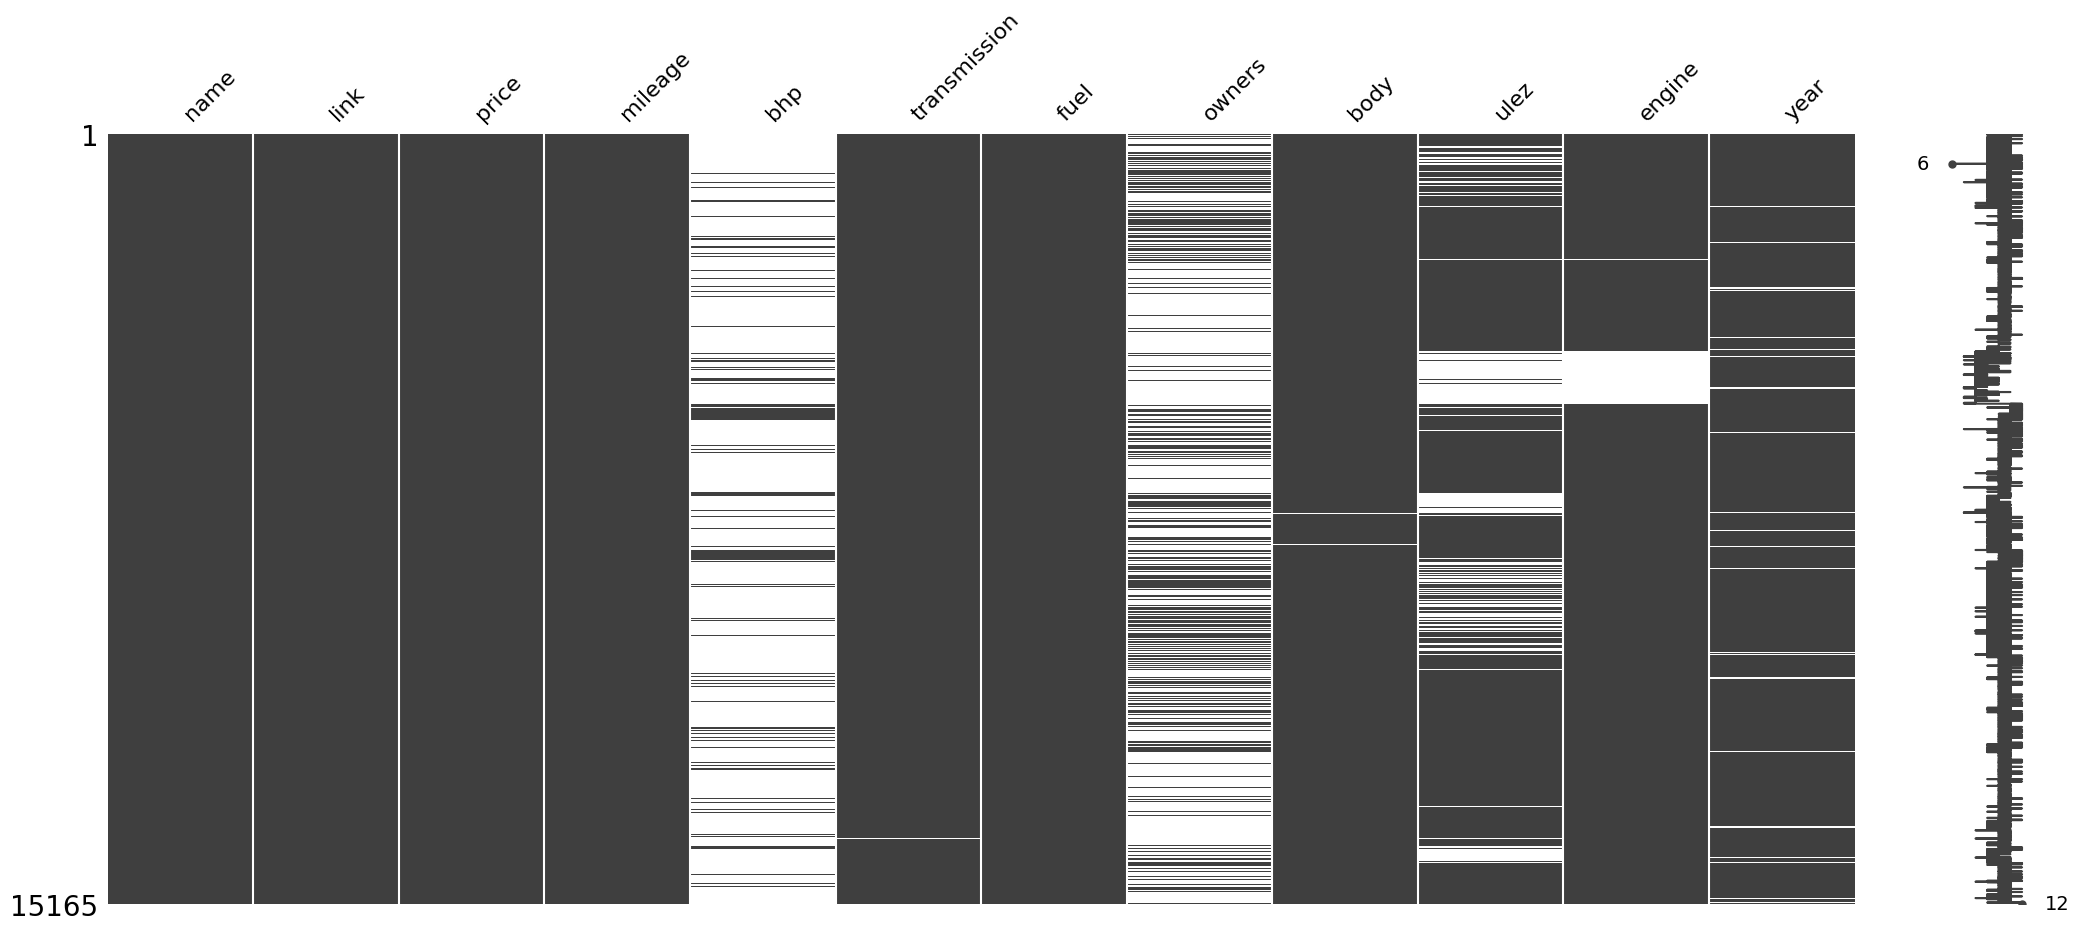

In [66]:
 mno.matrix(df);

In [67]:
df = df.reset_index(drop=True)

In [68]:
for col in ['transmission','fuel','mileage','body','year']:
    df = df.dropna(axis=0, subset=[col])

In [69]:
df.isna().sum()

name                0
link                0
price               0
mileage             0
bhp             13041
transmission        0
fuel                0
owners           9824
body                0
ulez             2969
engine           1006
year                0
dtype: int64

### **Data Pre-processing**

In [70]:
def clean():
    '''Function to Clean Data'''
    del df['link']
    
    df[['make', 'name']] = df['name'].str.split("_", expand=True)
    del df['make']
    
    columns = ['price', 'year', 'engine']
    regexes = [r"[^\s\w\d]", r" .*", r"L"]
    for col, regex in zip(columns, regexes):
        df[col] = df[col].apply(lambda x: re.sub(regex, "", str(x)))

In [71]:
clean()

In [72]:
df.head()

,name,price,mileage,bhp,transmission,fuel,owners,body,ulez,engine,year
0,Juke,2999,116000.0,NaN,Manual,Diesel,5.0,SUV,NaN,1.5,2010
1,Juke,3790,80000.0,NaN,Manual,Diesel,NaN,SUV,NaN,1.5,2010
2,Juke,5950,82000.0,115.0,Automatic,Petrol,2.0,SUV,ULEZ,1.6,2010
3,Juke,6499,35000.0,NaN,Automatic,Petrol,NaN,SUV,NaN,1.6,2010
4,Juke,3495,118000.0,NaN,Manual,Petrol,3.0,SUV,ULEZ,1.6,2010


In [73]:
df['name'].unique()

array(['Juke', 'Leaf', 'Micra', 'Navara', 'Qashqai', 'X-trail'],
      dtype=object)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14812 entries, 0 to 15164
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          14812 non-null  object 
 1   price         14812 non-null  object 
 2   mileage       14812 non-null  float64
 3   bhp           1771 non-null   float64
 4   transmission  14812 non-null  object 
 5   fuel          14812 non-null  object 
 6   owners        4988 non-null   float64
 7   body          14812 non-null  object 
 8   ulez          11843 non-null  object 
 9   engine        14812 non-null  object 
 10  year          14812 non-null  object 
dtypes: float64(3), object(8)
memory usage: 1.4+ MB


In [75]:
def dcast():
    '''Function to Cast Column Data Types'''
    df[['price', 'engine', 'year']] = df[['price', 'engine', 'year']].astype('float64')

In [76]:
dcast()

In [77]:
##ULEZ
df['ulez'].fillna('0', inplace = True)

def ulezbool(x, y):
    return {
        'Petrol': 1,
        'Electric': 1,
        'Diesel': 1 if y >= 2015 else 0
    }.get(x, 0)

In [78]:
df['ulez'] = df.apply(lambda x: ulezbool(x.fuel, x.year), axis=1)

In [79]:
df['ulez'].value_counts()

1    13250
0     1562
Name: ulez, dtype: int64

In [80]:
df.isna().sum()

name                0
price               0
mileage             0
bhp             13041
transmission        0
fuel                0
owners           9824
body                0
ulez                0
engine           1006
year                0
dtype: int64

In [81]:
object_cols = [col for col in df.columns if df[col].dtypes == 'object']
df[object_cols] = df[object_cols].astype(str).apply(lambda x: x.str.lower())

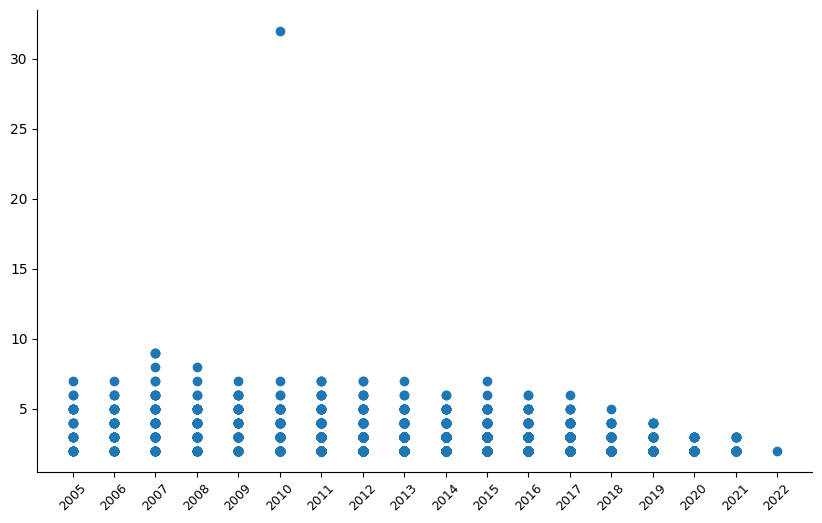

In [82]:
plt.figure(figsize=[10,6])
plt.scatter(data=df, x='year', y='owners')
plt.xticks(range(2005, 2023), rotation=45, size=9)
sns.despine()
plt.show()

In [83]:
df.drop(df[df['owners'] > 30].index, inplace=True)

In [84]:
df['owners'] = df['owners'].fillna(df['year'].map(df.groupby('year')['owners'].median()))

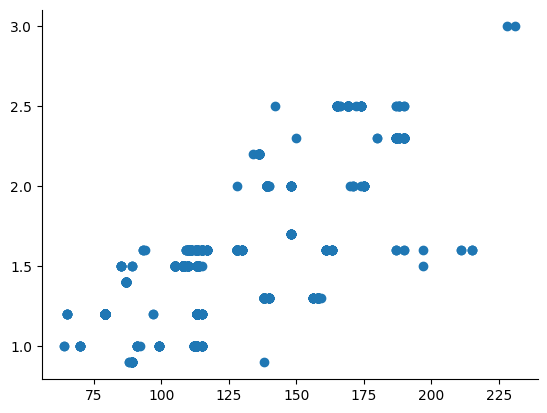

In [85]:
## lots of Nulls in BHP, can we impute?
plt.scatter(data=df, x='bhp', y='engine')
sns.despine()
plt.show()

In [86]:
del df['bhp']

In [87]:
df.isna().sum()

name               0
price              0
mileage            0
transmission       0
fuel               0
owners             0
body               0
ulez               0
engine          1006
year               0
dtype: int64

<br>

In [88]:
df.groupby(['name'])['engine'].median()

name
juke       1.5
leaf       1.0
micra      1.0
navara     2.3
qashqai    1.5
x-trail    1.6
Name: engine, dtype: float64

In [89]:
df['engine'] = df['engine'].fillna(df['name'].map(df.groupby('name')['engine'].median()))

In [90]:
df.isna().sum()

name            0
price           0
mileage         0
transmission    0
fuel            0
owners          0
body            0
ulez            0
engine          0
year            0
dtype: int64

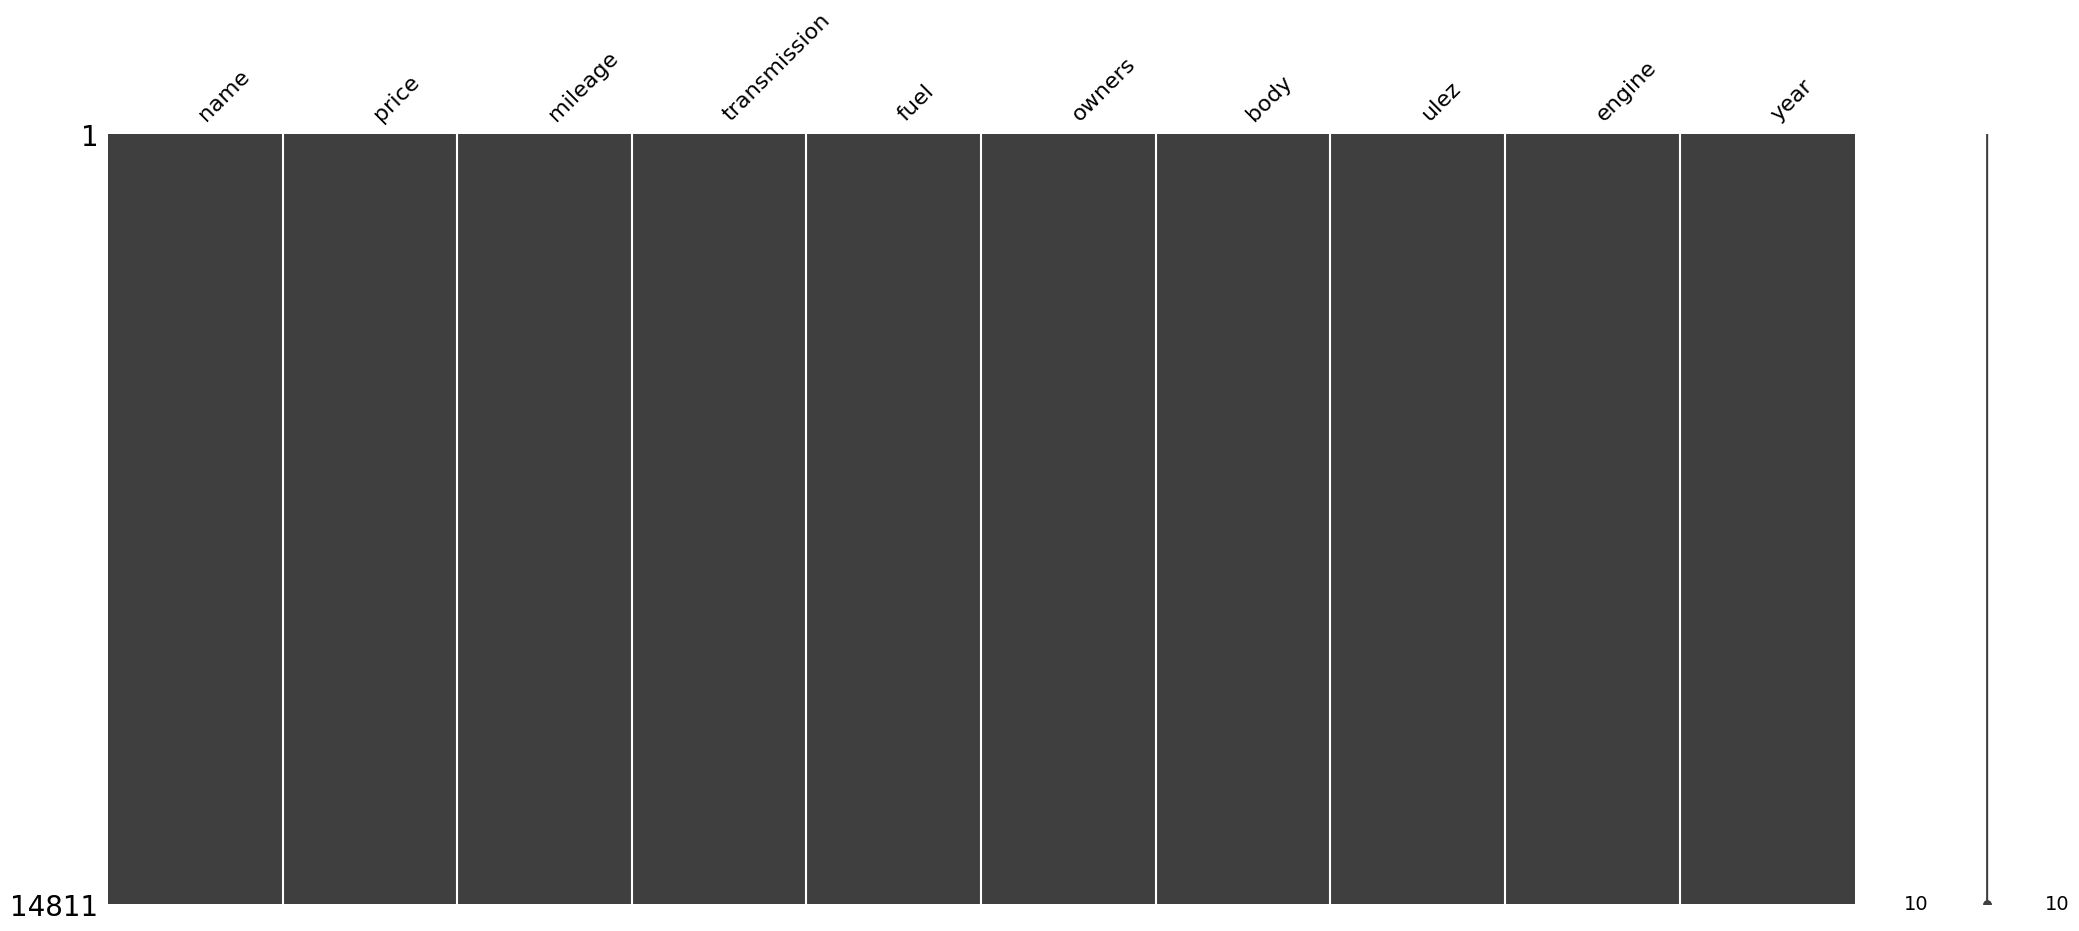

In [91]:
mno.matrix(df);

### **EDA**

In [92]:
def g(col):
    '''boxplot and histogram for corresponding numerical column'''
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=[10,6])
    sns.set_style("ticks")
    sns.boxplot(x=df[col], ax=ax_box, color='#1f77b4',linewidth=1.5,fliersize=3)
    sns.histplot(df[col], bins = 75, kde = True, color = '#1f77b4', ax=ax_hist, edgecolor='k', linewidth=0.7)
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    ax_box.set(xlabel='',yticks=[])
    ax_hist.set(ylabel='')
    plt.show()

In [93]:
def _probplt(col):
    '''probability plot for corresponding column'''
    stats.probplot(df.loc[:,col], plot = plt)
    sns.despine()
    plt.show()

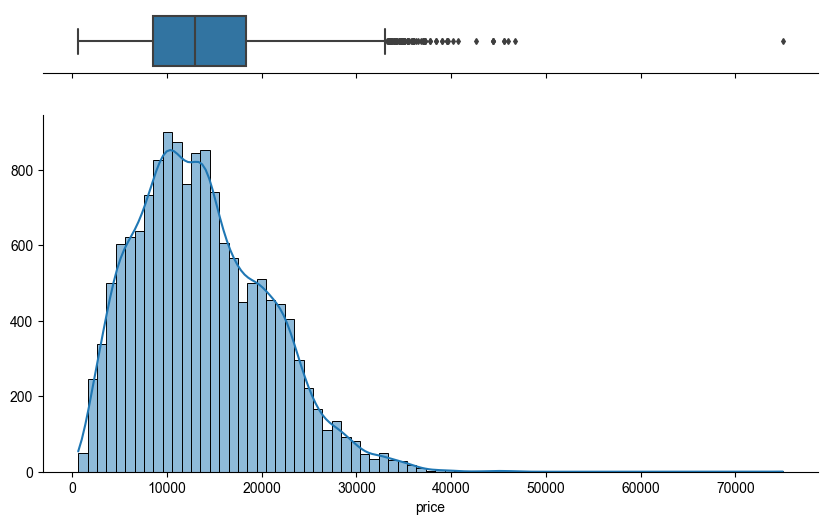

In [94]:
g('price')

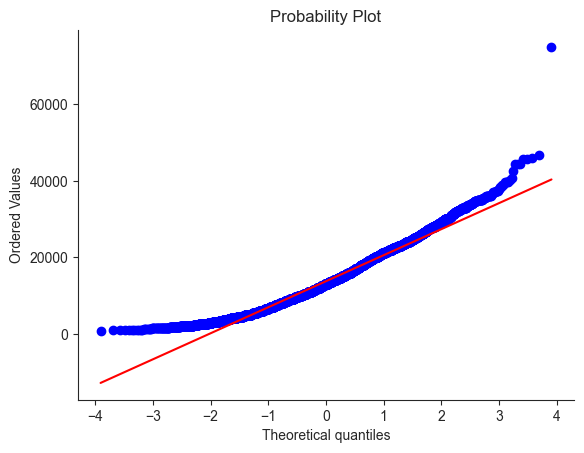

In [95]:
_probplt('price')

In [96]:
df.describe([.25,.5,.75,.9,.99,0.999]).transpose()

,count,mean,std,min,25%,50%,75%,90%,99%,99.9%,max
price,14811.0,13737.675984,6906.050371,650.0,8500.0,12995.0,18366.5,22997.0,32399.0,39112.05,74995.0
mileage,14811.0,43045.137263,32424.492117,5.0,17160.5,35165.0,62615.5,90800.0,133473.4,186190.00,222480.0
owners,14811.0,2.221997,0.592781,2.0,2.0,2.0,2.0,3.0,5.0,7.00,9.0
ulez,14811.0,0.894605,0.307072,0.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0
engine,14811.0,1.429924,0.365720,0.9,1.2,1.5,1.6,1.7,2.5,3.00,3.0
year,14811.0,2016.593478,3.538992,2005.0,2014.0,2017.0,2019.0,2021.0,2022.0,2022.00,2022.0


In [97]:
df.drop(df[df['price'] > 37193.328].index, inplace=True)

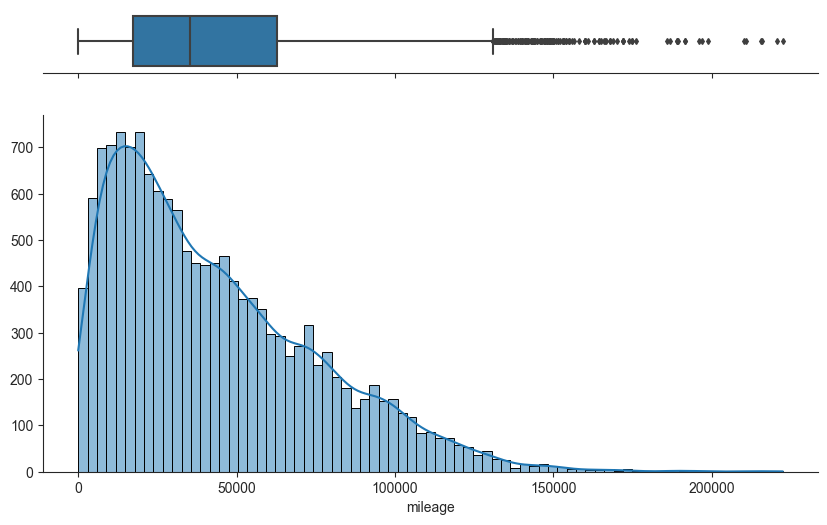

In [98]:
g('mileage')

In [99]:
df.drop(df[df['mileage'] > 130000].index, inplace=True)   #186889

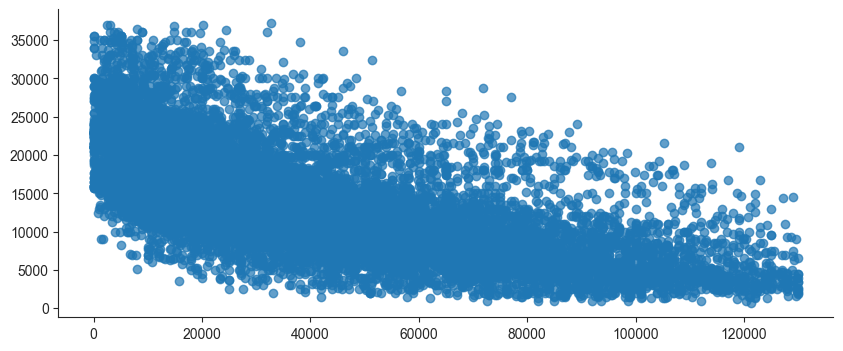

In [100]:
plt.figure(figsize=[10,4])
plt.scatter(data=df, x='mileage', y='price', alpha=0.7)
sns.despine()
plt.show()

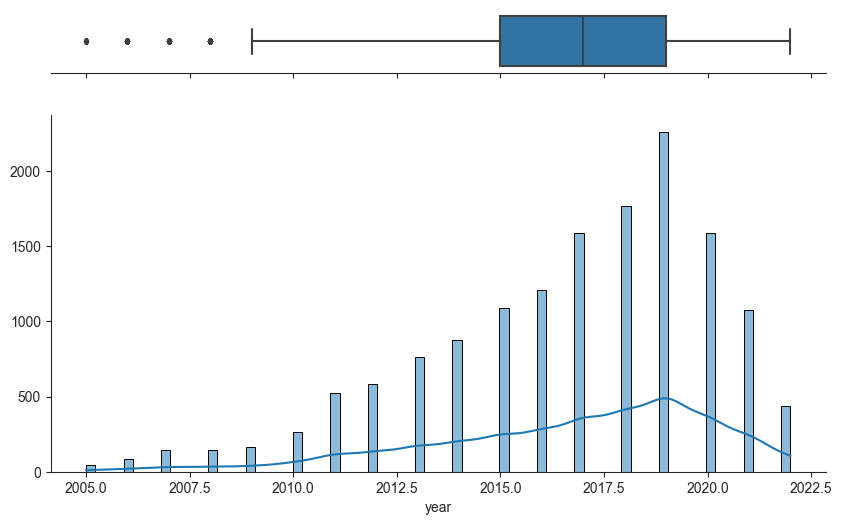

In [101]:
g('year')

In [102]:
df_removedata = df[(df['year'].astype(str).str.startswith('2021')) | (df['year'].astype(str).str.startswith('2022'))
                    | (df['year'].astype(str).str.startswith('2005')) | (df['year'].astype(str).str.startswith('2006'))].index
df = df.drop(df_removedata).copy()

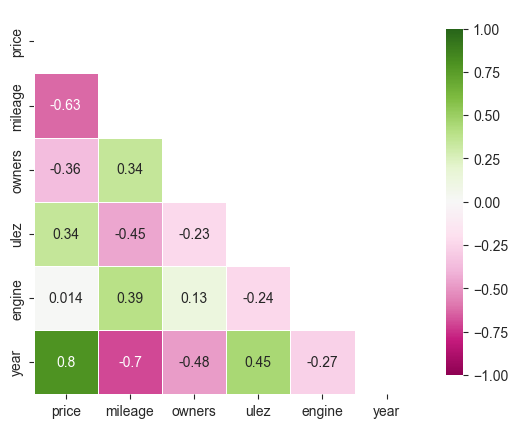

In [103]:
plt.figure(figsize = (7,5))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(df.corr(),
            annot = True,
            mask=mask,
            cmap = 'PiYG', center=0, vmin=-1, vmax=1, square=True, linewidth=0.5, cbar_kws={"shrink": 0.9})
plt.show()

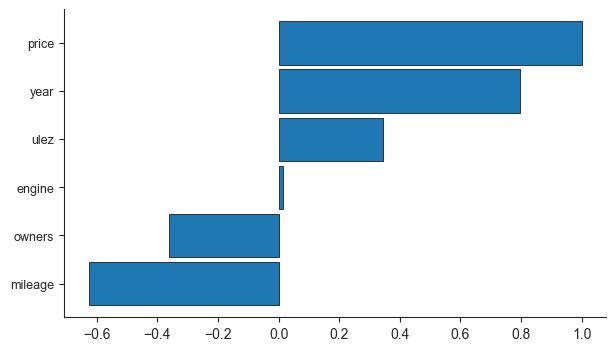

In [104]:
df.corr()['price'].sort_values(ascending=True).plot(
    kind='barh',figsize=[7,4], width=0.9, edgecolor='k', linewidth=0.5);
plt.yticks(fontsize=9)
sns.despine()

In [105]:
del df['engine']

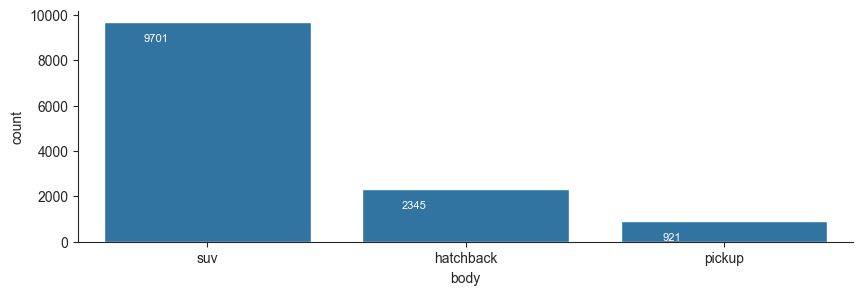

In [192]:
plt.figure(figsize=[10,3])
ax=sns.countplot(x=df['body'], color = '#1f77b4' )
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=8)
sns.despine()
plt.show()

In [107]:
df['body'].value_counts()

suv          9701
hatchback    2345
pickup        921
mpv             1
estate          1
Name: body, dtype: int64

In [108]:
df.drop(df[df['body'] == 'mpv'].index, inplace=True)

In [109]:
df.drop(df[df['body'] == 'estate'].index, inplace=True)

<br>

### **Modelling**

**Functions**

In [111]:
def _metrics(y_test,pred,model):
    '''Returns RSME and R^2 for the model'''
    mae = mean_absolute_error(y_test,pred)
    mse = mean_squared_error(y_test,pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test,pred)
    print(f'RMSE: {rmse:.3f} \nR^2: {r2:.3f}')

In [112]:
def tvp(p, t):
    '''Returns plot of y_test against y_pred & distribution of their difference''' 
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].scatter(t,p)
    axs[0].axline((0, 0), slope=1, color='red', alpha=0.7, linestyle='--')
    axs[0].set_xlim([-5000, 40000])
    axs[0].set_ylim([-5000, 40000])
    sns.despine()
    sns.histplot(t-p, ax=axs[1])
    plt.show()

In [113]:
def checkVIF(X):
    '''Function to calculate the VIF of a dataframe '''
    vif = pd.DataFrame()                ## Initialising an empty dataframe
    vif['Features'] = feature_cols      ## The features used in training
    vif['VIF'] = [variance_inflation_factor(X[feature_cols].values, i) for i in range(X[feature_cols].shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)   ## Round VIF to 2 decimal places for readability
    vif = vif.sort_values(by = "VIF", ascending = False)    ## Sorting VIF values in descending order to observe feature VIF scores
    return vif

<br>

In [114]:
df_model = df.copy()

In [115]:
df_model.head()

,name,price,mileage,transmission,fuel,owners,body,ulez,year
0,juke,2999.0,116000.0,manual,diesel,5.0,suv,0,2010.0
1,juke,3790.0,80000.0,manual,diesel,3.0,suv,0,2010.0
2,juke,5950.0,82000.0,automatic,petrol,2.0,suv,1,2010.0
3,juke,6499.0,35000.0,automatic,petrol,3.0,suv,1,2010.0
4,juke,3495.0,118000.0,manual,petrol,3.0,suv,1,2010.0


In [116]:
feature_cols = list(df_model.columns)        
feature_cols.remove('price')            

X = df_model[feature_cols]
y = df_model['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=df_model[['name']])

In [117]:
def feature_eng(df):
    for col in object_cols:
        df = pd.get_dummies(df, columns = [col], drop_first = True, prefix = col)
        df['age'] = datetime.date.today().year - df['year']
        df['age_log'] =  np.log(df['age'])
        df = sm.add_constant(df)
    del df['age']
    del df['year']
    return df

In [118]:
X_train = feature_eng(X_train)

In [119]:
X_train.head()

,const,mileage,owners,ulez,name_leaf,name_micra,name_navara,name_qashqai,name_x-trail,age_log,transmission_manual,fuel_electric,fuel_petrol,body_pickup,body_suv
10403,1.0,31806.0,2.0,1,0,0,0,1,0,1.945910,1,0,0,0,1
7434,1.0,112000.0,2.0,1,0,0,1,0,0,1.945910,1,0,0,1,0
10456,1.0,47000.0,3.0,1,0,0,0,1,0,1.945910,1,0,1,0,1
732,1.0,55485.0,2.0,1,0,0,0,0,0,2.302585,1,0,1,0,1
6713,1.0,21856.0,2.0,1,0,1,0,0,0,1.098612,0,0,1,0,0


In [120]:
## Scale mileage and age_log using MinMax Scaler
scaler = MinMaxScaler()
scaler.fit(X_train[['mileage', 'age_log']])         ## Fitting the model to X-train data
X_train[['mileage', 'age_log']] = scaler.transform(X_train[['mileage', 'age_log']])     ## Transforming the X_train mileage and age_log values

In [121]:
feature_cols = list(X_train.columns)

In [122]:
for col in ['name_leaf','body_pickup','body_suv']:
    feature_cols.remove(col)

In [123]:
lr=LinearRegression()
lr.fit(X_train[feature_cols],y_train)

LinearRegression()

In [124]:
X_test = feature_eng(X_test)

In [125]:
X_test = X_test[feature_cols]
X_test[['mileage', 'age_log']] = scaler.transform(X_test[['mileage', 'age_log']])

In [126]:
linreg_pred = lr.predict(X_test)

In [127]:
_metrics(y_test,linreg_pred,lr)

RMSE: 1769.712 
R^2: 0.913


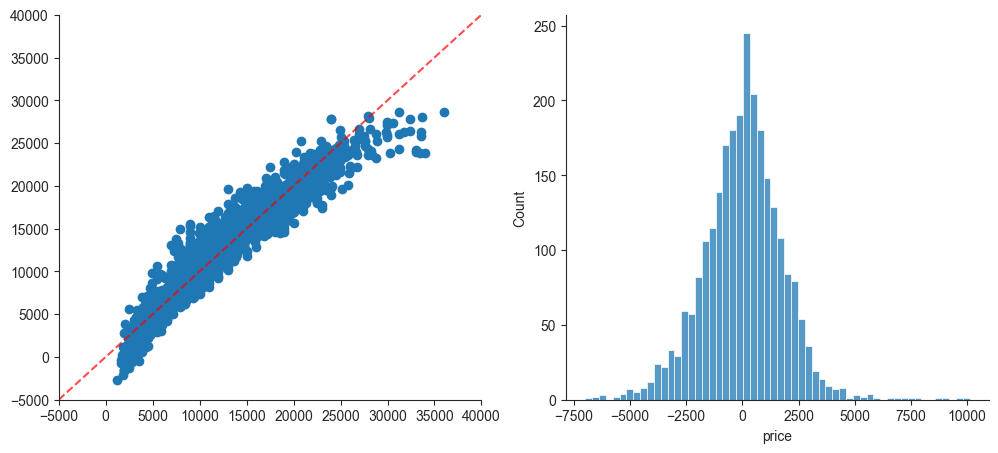

In [128]:
tvp(linreg_pred,y_test)

In [129]:
checkVIF(X_train)   ## If VIF >= 5, test to see if the removal of said feature reduces the multi-co-linearity

,Features,VIF
0,const,42.23
8,age_log,2.47
1,mileage,2.44
11,fuel_petrol,1.93
10,fuel_electric,1.68
6,name_qashqai,1.57
5,name_navara,1.56
3,ulez,1.53
7,name_x-trail,1.37
9,transmission_manual,1.31


<br><br><br><br>

**More Modelling**

In [131]:
rf = RandomForestRegressor(random_state = 0)

In [132]:
rf.fit(X_train[feature_cols], y_train)

RandomForestRegressor(random_state=0)

In [133]:
rf_y_pred = rf.predict(X_test)

In [134]:
_metrics(y_test, rf_y_pred,rf)

RMSE: 1587.370 
R^2: 0.930


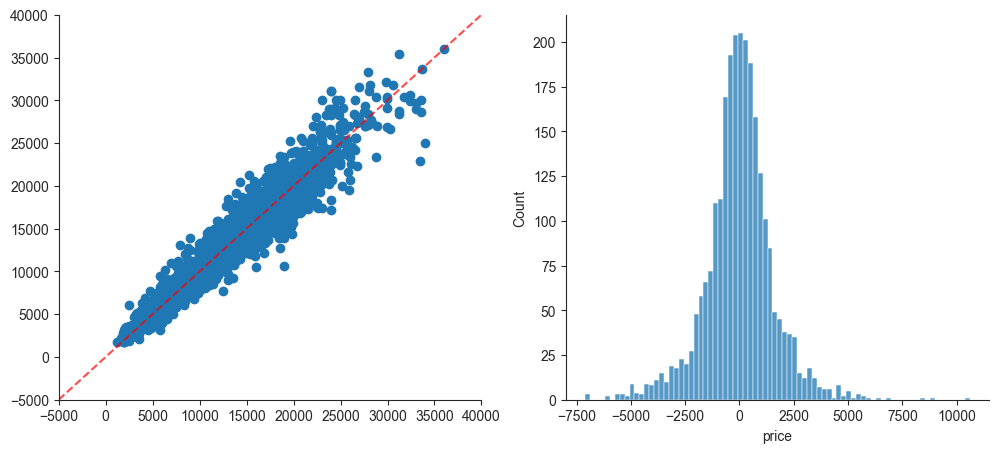

In [135]:
tvp(rf_y_pred,y_test)

In [128]:
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


In [134]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [5,10,20,30, None],
    'max_features': [1,5,'sqrt', 'auto'],
    'min_samples_leaf': [1],
    'min_samples_split': [2,3,4],
    'n_estimators': [50,70,90,100,110,150,200,300]
}

In [135]:
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring='r2', cv = 3, n_jobs = -1, verbose = 2)

In [136]:
#grid_search.fit(X_train[feature_cols],y_train)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'max_depth': [5, 10, 20, 30, None],
                         'max_features': [1, 5, 'sqrt', 'auto'],
                         'min_samples_leaf': [1],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [50, 70, 90, 100, 110, 150, 200, 300]},
             scoring='r2', verbose=2)

In [137]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 200}

In [136]:
rf_hyper_model= RandomForestRegressor(bootstrap = True,max_depth= 10,max_features= 'auto',min_samples_leaf= 1,min_samples_split= 4,n_estimators= 200)

In [137]:
rf_hyper_model.fit(X_train[feature_cols],y_train)

RandomForestRegressor(max_depth=10, min_samples_split=4, n_estimators=200)

In [138]:
rf_hyper_pred=rf_hyper_model.predict(X_test)

In [139]:
_metrics(y_test, rf_hyper_pred,rf_hyper_model)

RMSE: 1433.676 
R^2: 0.943


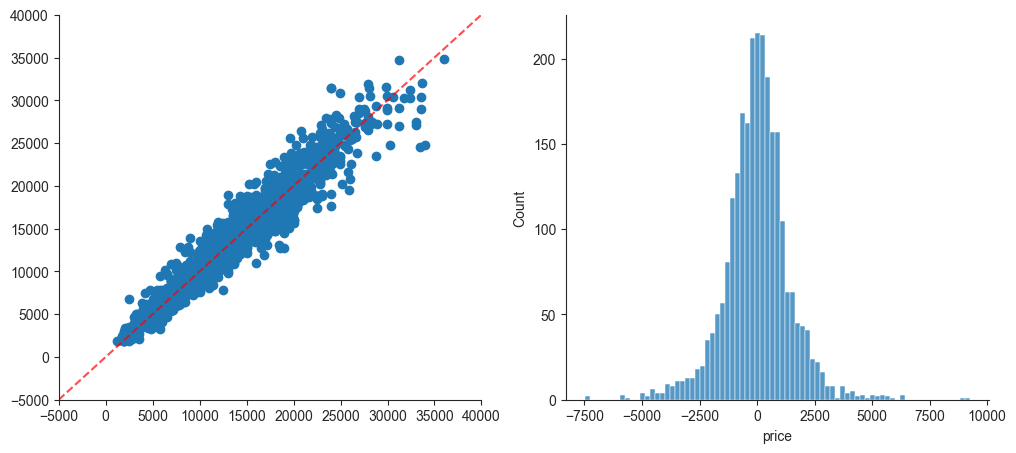

In [140]:
tvp(rf_hyper_pred, y_test)

<br><br><br>

In [141]:
lgbm_model = LGBMRegressor(random_state = 42, n_estimators = 90)

In [142]:
lgbm_model.fit(X_train[feature_cols],y_train)

LGBMRegressor(n_estimators=90, random_state=42)

In [143]:
lgbm_pred = lgbm_model.predict(X_test)

In [144]:
_metrics(y_test, lgbm_pred,lgbm_model)

RMSE: 1383.358 
R^2: 0.947


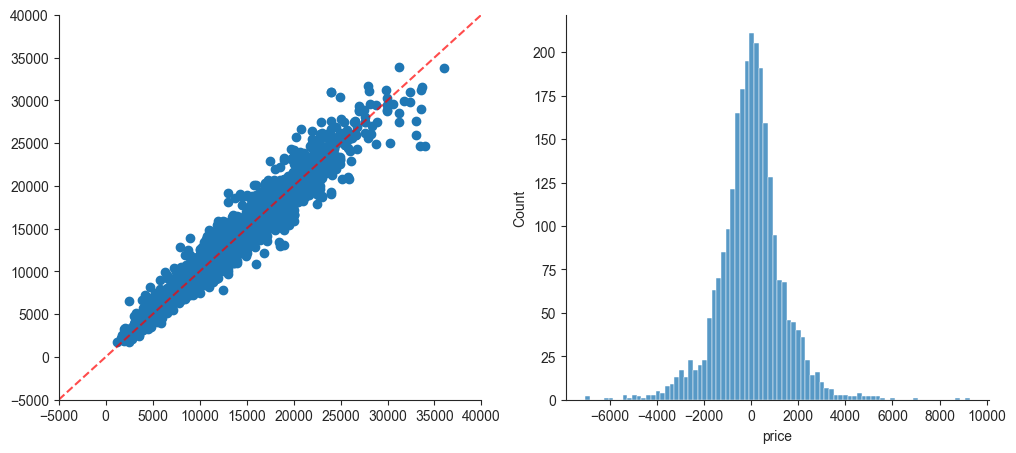

In [145]:
tvp(lgbm_pred,y_test)

<br><br><br>

In [146]:
RegModel=XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=200, objective='reg:squarederror', booster='gbtree')

In [147]:
XGB=RegModel.fit(X_train[feature_cols],y_train)
xg_pred=XGB.predict(X_test)

In [148]:
_metrics(y_test, xg_pred,XGB)

RMSE: 1409.236 
R^2: 0.945


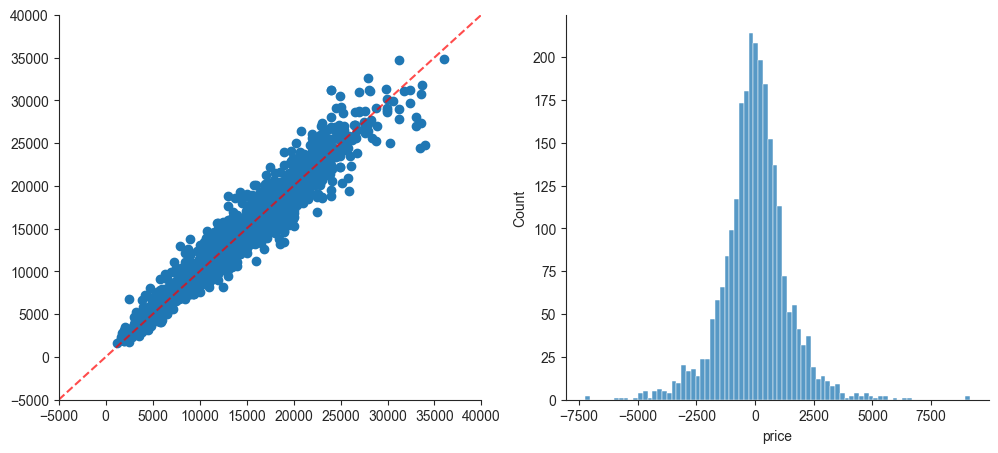

In [149]:
tvp(xg_pred, y_test)

<br><br><br>

In [150]:
catb_model = CatBoostRegressor(verbose=0, n_estimators=150)

In [151]:
catb_model.fit(X_train[feature_cols],y_train)

In [152]:
cat_pred = catb_model.predict(X_test)

In [153]:
_metrics(y_test, cat_pred,catb_model)

RMSE: 1393.145 
R^2: 0.946


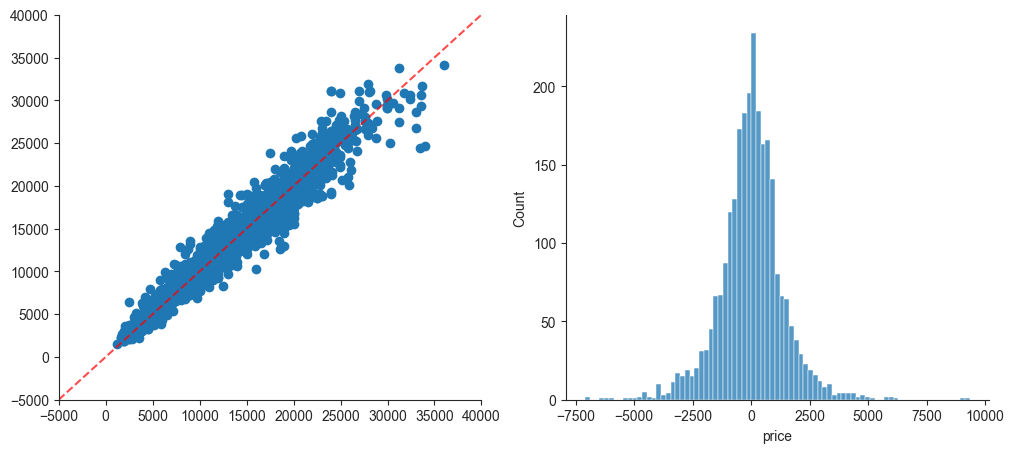

In [154]:
tvp(cat_pred,y_test)

<br><br><br>

### ***DEEP LEARNING***

In [165]:
def build_and_compile_model(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
    ])

    model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [166]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plt.show()

In [170]:
t = np.array(X_train[feature_cols])

normalizer = layers.Normalization(input_shape=[12,], axis=None)
normalizer.adapt(t)

In [171]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 12)               3         
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 128)               1664      
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9,988
Trainable params: 9,985
Non-trainable params: 3
_________________________________________________________________


In [ ]:
history = dnn_model.fit(
    X_train[feature_cols],
    y_train,
    validation_split=0.1,
    verbose=1, epochs=200)

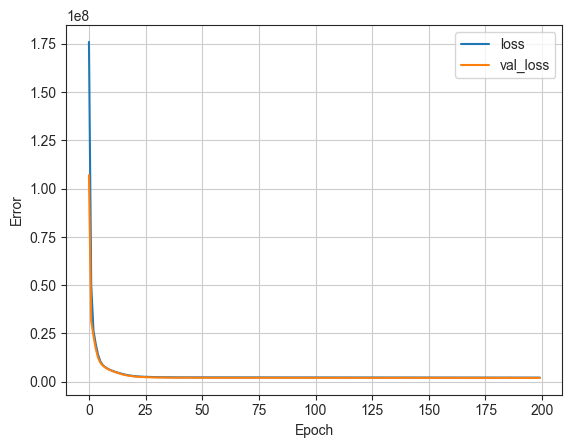

In [173]:
plot_loss(history)

In [174]:
dnn_pred = dnn_model.predict(X_test).flatten()

82/82 [==============================] - 0s 1ms/step


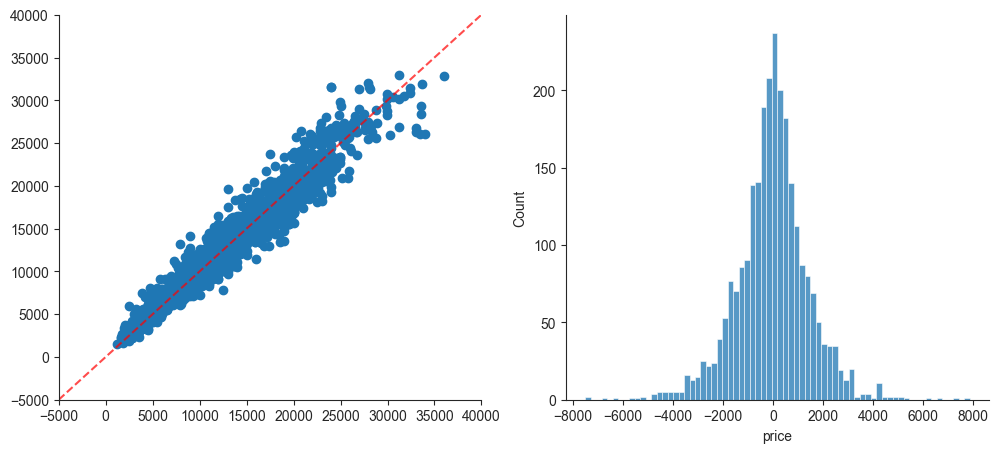

In [175]:
tvp(dnn_pred,y_test)

In [176]:
_metrics(y_test, dnn_pred,dnn_model)

RMSE: 1454.896 
R^2: 0.941


In [177]:
if os.path.isfile('wbaac_model.h5') is False:
    dnn_model.save('wbaac_model.h5')

In [178]:
wbaac_model = load_model('wbaac_model.h5')

In [179]:
dnn_pred_load = wbaac_model.predict(X_test).flatten()

82/82 [==============================] - 0s 1ms/step


In [180]:
_metrics(y_test, dnn_pred_load,wbaac_model)

RMSE: 1454.896 
R^2: 0.941


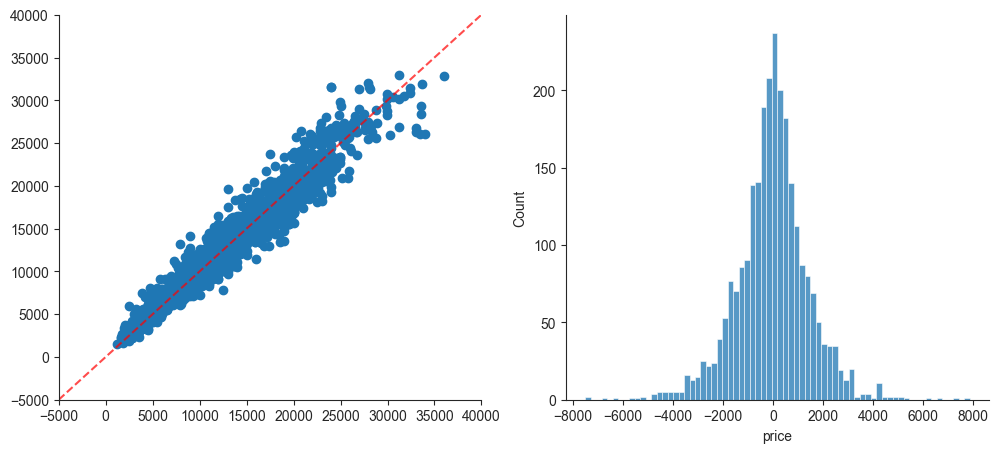

In [181]:
tvp(dnn_pred_load,y_test)